# Using Gaussian Processes to Address the Issues of Predicting Financial Time Series

### Imports

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel, DotProduct, RBF
from sklearn.metrics import r2_score

import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# so warnings dont clutter notebook
import warnings
warnings.filterwarnings('ignore')

In [2]:
if os.path.isdir('Figures/'):
    path = './Figures/'
else:
    path = './'

### Generating and inspecting the dataset

In [3]:
# Define the time variable t
n_samples = 100
t = np.arange(n_samples)
data = pd.DataFrame({'t': t})

# Curate the fluctuating variable over the time-series (i.e. return)
asset = 'ETH/USD'
pair = asset.replace('/', '-')
df = pd.read_csv(f'../Datasets/Data/data_{pair}.csv')

closing = df.Close

# convert time data into datetime object, and extract closing prices
df.Time = pd.to_datetime(df.Time)
df.set_index(df.Time, inplace=True)
prices = pd.DataFrame({'Price': df.Close})

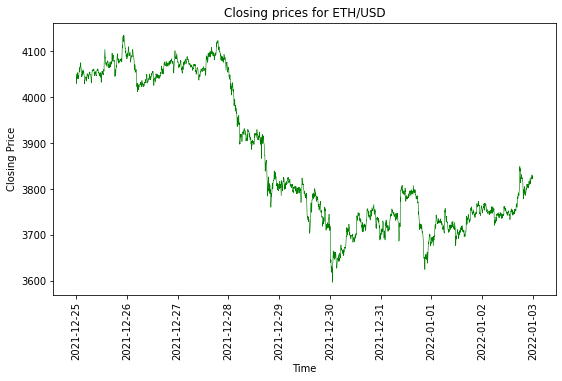

In [4]:
# Plot of all closing prices for asset
fig = plt.figure(figsize=(9, 5))
plt.plot(prices, color='green', linewidth=0.6)
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title(f'Closing prices for {asset}')
plt.xticks(rotation=90)
plt.savefig(path + 'closing-prices-global.png')
plt.show()

In [5]:
# Closing prices statistics
closing.describe()

count    2592.000000
mean     3868.862114
std       154.434284
min      3597.300000
25%      3738.575000
50%      3801.050000
75%      4051.100000
max      4135.400000
Name: Close, dtype: float64

In [6]:
log_returns = np.log(closing) - np.log(closing.shift(1))
log_returns.dropna(inplace=True)
log_returns = np.array(log_returns)
abs_returns = np.abs(np.array(log_returns))

returns_pos = np.array(log_returns[log_returns >= 0])
returns_neg = np.abs(np.array(log_returns[log_returns < 0]))

print(f"max no. absolute returns in dataset: {abs_returns.shape[0]}")

np.random.seed(22)
rand_index = np.random.randint(0, abs_returns.shape[0] - n_samples)

data['y'] = abs_returns[rand_index: rand_index + n_samples]
data['y_signed'] = log_returns[rand_index: rand_index + n_samples]

data.head()

max no. absolute returns in dataset: 2591


,t,y,y_signed
0,0,0.001131,0.001131
1,1,0.000592,0.000592
2,2,0.000431,-0.000431
3,3,0.000943,-0.000943
4,4,0.002341,0.002341


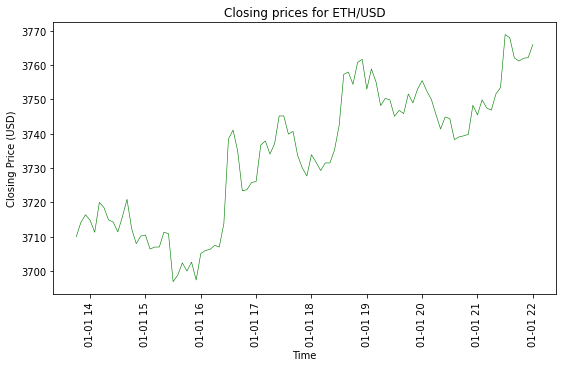

                      Price
Time                       
2022-01-01 13:45:00  3710.0
2022-01-01 13:50:00  3714.2
2022-01-01 13:55:00  3716.4
2022-01-01 14:00:00  3714.8
2022-01-01 14:05:00  3711.3
                      Price
Time                       
2022-01-01 21:40:00  3762.1
2022-01-01 21:45:00  3761.2
2022-01-01 21:50:00  3762.0
2022-01-01 21:55:00  3762.2
2022-01-01 22:00:00  3766.0


In [7]:
# Plot of selected closing prices for asset
fig = plt.figure(figsize=(9, 5))
plt.plot(prices[rand_index: rand_index + n_samples], color='green', linewidth=0.6)
plt.xlabel('Time')
plt.ylabel('Closing Price (USD)')
plt.title(f'Closing prices for {asset}')
plt.xticks(rotation=90)
plt.savefig(path + 'closing-prices-local.png')
plt.show()

print(prices[rand_index: rand_index + n_samples].head())
print(prices[rand_index: rand_index + n_samples].tail())

#### Stationarity tests

In [8]:
# Use the Augmented Dickey-Fuller test to check whether original dataset (closing prices) is stationary
result_close = adfuller(np.array(closing))
p = result_close[1]

print('Closing prices stationarity:')
print(f'\tp-value: {p}')

if p <= 0.05:
	print("\t-> Null hypothesis rejected")
else:
	print("\t-> Null hypothesis cannot be rejected")

Closing prices stationarity:
	p-value: 0.5939162429250302
	-> Null hypothesis cannot be rejected


#### Correlation tests

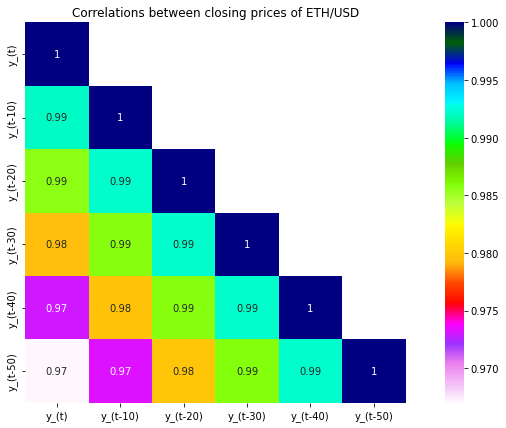

In [9]:
# Evaluate correlations between variables in prices dataset
# construct shifted dataset of closing values
y_t = pd.Series(np.array(closing))
close_df = pd.DataFrame(y_t, columns=['y_(t)'])

for i in range(10, 60, 10):
    close_df[f'y_(t-{i})'] = y_t.shift(i)

close_df = close_df.dropna()

# compute the correlation of closing values and closing values shifted back through time-series
corr_matrix_close = close_df.corr()

# define a mask that hides the values in the upper triangular matrix
mask = np.triu(np.ones_like(corr_matrix_close, dtype=bool), k=1)

# genrate heatmap that uses this mask and map
fig = plt.figure(figsize=(14, 7))
sns.heatmap(corr_matrix_close, mask=mask, cmap=plt.cm.gist_ncar_r, square=True, annot=True)
plt.title(f"Correlations between closing prices of {asset}")
plt.savefig(path + 'correlations-prices.png')
plt.show()

#### Logarithmic returns

In [10]:
# positive and negative returns
data['y_+'] = data['y_signed'][data['y_signed'] >= 0]
data['y_-'] = np.abs(data['y_signed'][data['y_signed'] < 0])
data['y_+'] = data['y_+']
data['y_-'] = data['y_-']

data.head()

,t,y,y_signed,y_+,y_-
0,0,0.001131,0.001131,0.001131,NaN
1,1,0.000592,0.000592,0.000592,NaN
2,2,0.000431,-0.000431,NaN,0.000431
3,3,0.000943,-0.000943,NaN,0.000943
4,4,0.002341,0.002341,0.002341,NaN


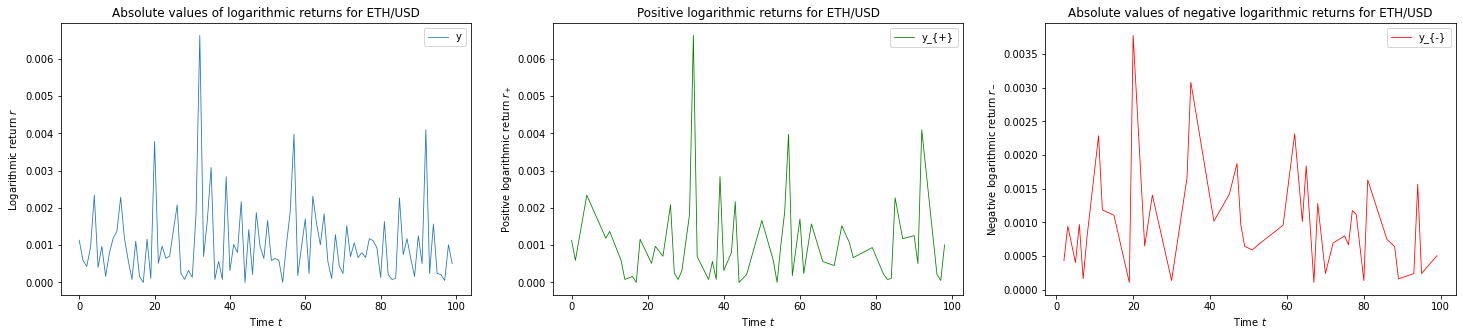

In [11]:
# Plot of absolute log returns, positive returns, and absolute values of negatve returns
fig, ax = plt.subplots(1, 3, figsize=(25, 5))

sns.lineplot(x='t', y='y', data=data, label=r'y', ax=ax[0], linewidth=0.8) 
ax[0].set(title=f'Absolute values of logarithmic returns for {asset}', xlabel=r'Time $t$', ylabel=r'Logarithmic return $r$')
ax[0].legend()

sns.lineplot(x='t', y='y_+', data=data, label=r'y_{+}', ax=ax[1], linewidth=0.8, color='g') 
ax[1].set(title=f'Positive logarithmic returns for {asset}', xlabel=r'Time $t$', ylabel=r'Positive logarithmic return $r_{+}$')
ax[1].legend()

sns.lineplot(x='t', y='y_-', data=data, label=r'y_{-}', ax=ax[2], linewidth=0.8, color='r') 
ax[2].set(title=f'Absolute values of negative logarithmic returns for {asset}', xlabel=r'Time $t$', ylabel=r'Negative logarithmic return $r_{-}$')
ax[2].legend()

plt.savefig(path + 'logarithmic-returns.png')
plt.show()

#### Stationarity tests

In [12]:
# Use the augmented dickey-fuller test to establish whether de-trended dataset (log returns) is stationary
result_rets = adfuller(np.array(data['y_signed']))
p = result_rets[1]

print('Log returns stationarity:')
print(f'\tp-value: {p}')

if p <= 0.05:
	print("\t-> Null hypothesis rejected")
else:
	print("\t-> Null hypothesis cannot be rejected")

Log returns stationarity:
	p-value: 8.305550668242478e-13
	-> Null hypothesis rejected


#### Correlation tests

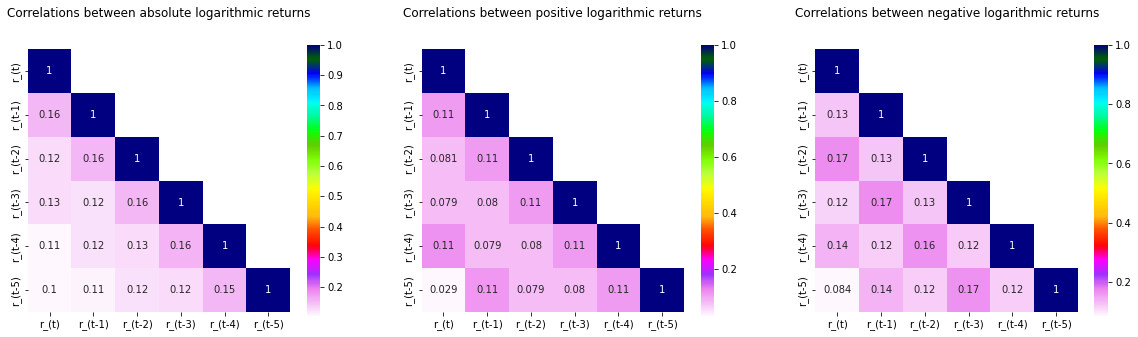

In [13]:
# Evaluate correlations between variables in logarithmic returns dataset
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# construct shifted dataset of closing values
rets_t = pd.Series(np.array(abs_returns))
rets_df = pd.DataFrame(rets_t, columns=['r_(t)'])

for i in range(1, 6, 1):
    rets_df[f'r_(t-{i})'] = rets_t.shift(i)

rets_df = rets_df.dropna()

# compute the correlation of absolute returns and shifted values back through time-series
corr_matrix_rets = rets_df.corr()

# define a mask that hides the values in the upper triangular matrix
mask_1 = np.triu(np.ones_like(corr_matrix_rets, dtype=bool), k=1)

# genrate heatmap that uses this mask and map
sns.heatmap(corr_matrix_rets, mask=mask_1, cmap=plt.cm.gist_ncar_r, square=True, annot=True, ax=ax[0])
ax[0].set_title("Correlations between absolute logarithmic returns", y=1.1)

# Repeat for positive returns
rpos_t = pd.Series(np.array(returns_pos))
rpos_df = pd.DataFrame(rpos_t, columns=['r_(t)'])

for i in range(1, 6, 1):
    rpos_df[f'r_(t-{i})'] = rpos_t.shift(i)

rpos_df = rpos_df.dropna()

corr_matrix_rpos = rpos_df.corr()
mask_2 = np.triu(np.ones_like(corr_matrix_rpos, dtype=bool), k=1)

sns.heatmap(corr_matrix_rpos, mask=mask_2, cmap=plt.cm.gist_ncar_r, square=True, annot=True, ax=ax[1])
ax[1].set_title("Correlations between positive logarithmic returns", y=1.1)

# Repeat for negative returns
rneg_t = pd.Series(np.array(returns_neg))
rneg_df = pd.DataFrame(rneg_t, columns=['r_(t)'])

for i in range(1, 6, 1):
    rneg_df[f'r_(t-{i})'] = rneg_t.shift(i)

rneg_df = rneg_df.dropna()

corr_matrix_rneg = rneg_df.corr()
mask_3 = np.triu(np.ones_like(corr_matrix_rneg, dtype=bool), k=1)

sns.heatmap(corr_matrix_rneg, mask=mask_3, cmap=plt.cm.gist_ncar_r, square=True, annot=True, ax=ax[2])
ax[2].set_title("Correlations between negative logarithmic returns", y=1.1)

plt.savefig(path + 'correlations-returns.png')
plt.show()

#### Train-test split

In [14]:
# split data into training and testing sets
# X = times; y = return
X = data['t'].values.reshape(n_samples, 1)
y = data['y'].values.reshape(n_samples, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [15]:
# Statistics of training dataset
pd.Series(y_train.flatten()).describe()

count    70.000000
mean      0.001105
std       0.001108
min       0.000000
25%       0.000344
50%       0.000873
75%       0.001532
max       0.006629
dtype: float64

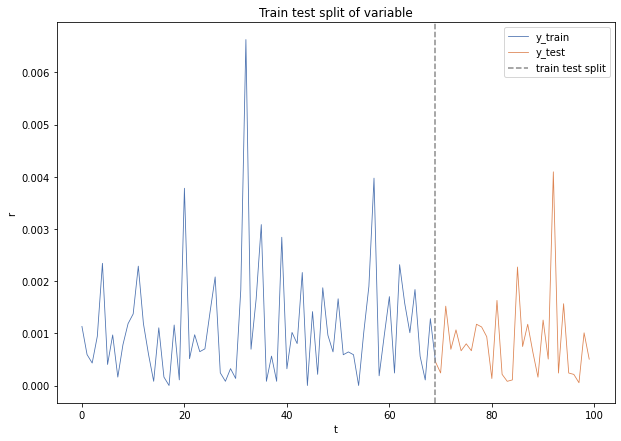

In [16]:
# plot the split datasets
fig, ax = plt.subplots(figsize=(10, 7))

X_test_extended = np.append(X_train[-1], X_test.flatten())
y_test_extended = np.append(y_train[-1], y_test.flatten())

sns.lineplot(x=X_train.flatten(), y=y_train.flatten(), color=sns.color_palette(palette='deep')[0], ax=ax, linewidth=0.8, label='y_train') 
sns.lineplot(x=X_test_extended, y=y_test_extended, color=sns.color_palette(palette='deep')[1], ax=ax, linewidth=0.8, label='y_test') 

ax.axvline(x=X_train.flatten()[-1], color=sns.color_palette(palette='deep')[7], linestyle='--', label='train test split')

ax.legend()
ax.set(title='Train test split of variable', xlabel='t', ylabel='r')

plt.savefig(path + 'train-test-split.png')
plt.show()

### Defining the Gaussian process

In [17]:
# define the kernel of the gaussian process model

# WhiteKernel models the noise of the signal as iid
# 1 hyperparameter `noise_level`
whitekernel = WhiteKernel(noise_level=1, noise_level_bounds=(1e-3, 1e3))

# ConstantKernel scales the magnitude of the kernel by modifying the mean of the Gaussian process
# 1 hyperparam `constant_value`
constantkernel = ConstantKernel(constant_value=1, constant_value_bounds=(1e-5, 1e5))

# ESSKernel allows the modelling of repeating functions
# 2 hyperparams `length_scale` and `periodicity`
esskernel =  ExpSineSquared(length_scale=1e-3, length_scale_bounds=(1e-8, 1e2), periodicity=60, periodicity_bounds=(40, 80))

# sum/product kernel
kernel = whitekernel + constantkernel * esskernel

Gaussian Process model hhyperparameters:
- `alpha` = variance of iid noise added to labels
- `normalise_y` = constant mean function used (False => zero mean; True => mean of training data)
- `n_restarts_optimizer` = number of different initialisations to try during tuning
- `optimiser` = default is given

In [18]:
# specify Gaussian model hyperparameters
alpha = 0.0
normalise_y = True
n_restarts_optimiser = 10
optimiser = 'fmin_l_bfgs_b'

# initialise the gaussian process regression model
gp = GaussianProcessRegressor(
    kernel=kernel,
    optimizer=optimiser,
    n_restarts_optimizer=n_restarts_optimiser,
    normalize_y=normalise_y,
    alpha=alpha
)

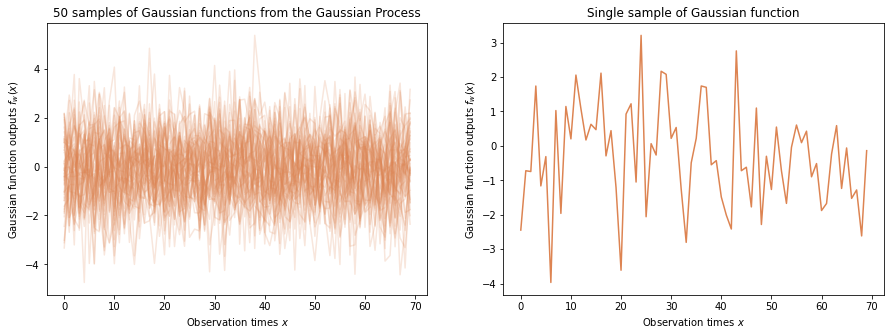

In [19]:
# sample from prior distribution
n_samples = 50
x_plot = X_train[..., 0].copy()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

prior_samples = gp.sample_y(X=X_train, n_samples=n_samples)
single_sample = gp.sample_y(X=X_train, n_samples=1).squeeze(1)

for i in range(n_samples):
    sns.lineplot(x=x_plot, y=prior_samples[:, i], color=sns.color_palette(palette='deep')[1], alpha=0.2, ax=ax[0])

ax[0].set(title='50 samples of Gaussian functions from the Gaussian Process', xlabel=r'Observation times $x$', ylabel=r'Gaussian function outputs $f_w(x)$')

sns.lineplot(x=x_plot, y=single_sample, color=sns.color_palette(palette='deep')[1], ax=ax[1])
ax[1].set(title='Single sample of Gaussian function', xlabel=r'Observation times $x$', ylabel=r'Gaussian function outputs $f_w(x)$')

plt.savefig(path + 'gp-prior-distribution.png')
plt.show()

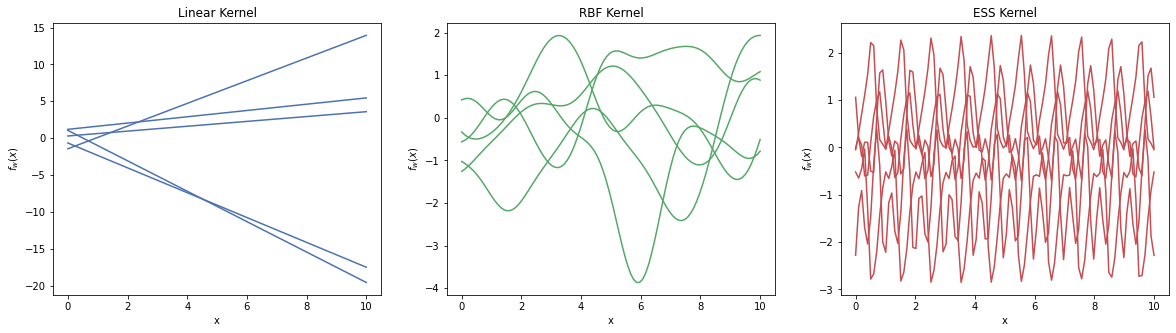

In [20]:
# Linear kernel
gp_linear = GaussianProcessRegressor(
    kernel=DotProduct()
)

# RBF kernel
gp_rbf = GaussianProcessRegressor(
    kernel=RBF()
)

# Exponential Sine Squared kernel
gp_ess = GaussianProcessRegressor(
    kernel=ExpSineSquared()
)

# plot a variety of random kernel functions from each type of kernel
n_samples = 5
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

x_plot = np.linspace(0, 10, 100)
x_space = x_plot.reshape(x_plot.shape[0], 1)

prior_samples_linear = gp_linear.sample_y(X=x_space, n_samples=n_samples)
prior_samples_rbf = gp_rbf.sample_y(X=x_space, n_samples=n_samples)
prior_samples_ess = gp_ess.sample_y(X=x_space, n_samples=n_samples)

for i in range(n_samples):
    sns.lineplot(x=x_plot, y=prior_samples_linear[:, i], color=sns.color_palette(palette='deep')[0], ax=ax[0])
ax[0].set(title='Linear Kernel', xlabel=r'x', ylabel=r'$f_w(x)$')

for i in range(n_samples):
    sns.lineplot(x=x_plot, y=prior_samples_rbf[:, i], color=sns.color_palette(palette='deep')[2], ax=ax[1])
ax[1].set(title='RBF Kernel', xlabel=r'x', ylabel=r'$f_w(x)$')

for i in range(n_samples):
    sns.lineplot(x=x_plot, y=prior_samples_ess[:, i], color=sns.color_palette(palette='deep')[3], ax=ax[2])
ax[2].set(title='ESS Kernel', xlabel=r'x', ylabel=r'$f_w(x)$')

plt.savefig(path + 'varying-kernels.png')
plt.show()

### Fitting the GP

In [21]:
# tune model hyperparameters through MLE
gp.fit(X_train, y_train)
print("Optimised kernel params: \n", pd.Series(gp.kernel_.get_params()))

Optimised kernel params: 
 k1                                                  WhiteKernel(noise_level=0.496)
k2                               0.738**2 * ExpSineSquared(length_scale=0.001, ...
k1__noise_level                                                           0.495952
k1__noise_level_bounds                                             (0.001, 1000.0)
k2__k1                                                                    0.738**2
k2__k2                           ExpSineSquared(length_scale=0.001, periodicity...
k2__k1__constant_value                                                    0.544278
k2__k1__constant_value_bounds                                    (1e-05, 100000.0)
k2__k2__length_scale                                                         0.001
k2__k2__periodicity                                                      60.001786
k2__k2__length_scale_bounds                                         (1e-08, 100.0)
k2__k2__periodicity_bounds                                  

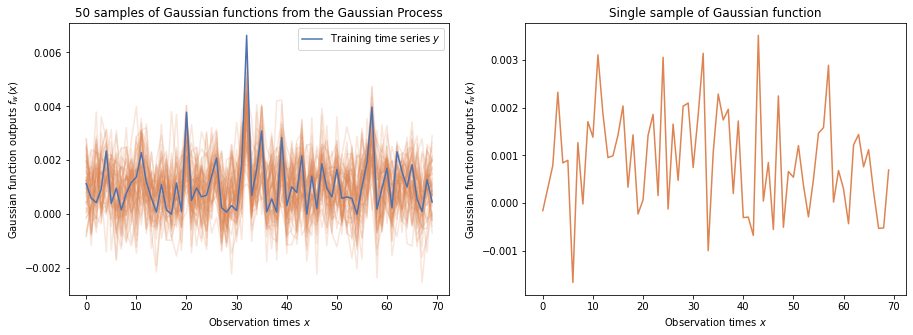

In [22]:
# sample from posterior distribution
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
n_samples = 50
post_samples = gp.sample_y(X=X_train, n_samples=n_samples).squeeze(1)
single_post_sample = gp.sample_y(X=X_train, n_samples=1).squeeze(1).squeeze(1)
x_plot = X_train[..., 0].copy()

for i in range(n_samples):
    sns.lineplot(x=x_plot, y=post_samples[:, i], color=sns.color_palette(palette='deep')[1], alpha=0.2, ax=ax[0])

sns.lineplot(x=x_plot, y=y_train[:, 0], color=sns.color_palette(palette='deep')[0], ax=ax[0], label=r'Training time series $y$')

ax[0].set(title='50 samples of Gaussian functions from the Gaussian Process', xlabel=r'Observation times $x$', ylabel=r'Gaussian function outputs $f_w(x)$')
ax[0].legend()

sns.lineplot(x=x_plot, y=single_post_sample, color=sns.color_palette(palette='deep')[1], ax=ax[1])
ax[1].set(title='Single sample of Gaussian function', xlabel=r'Observation times $x$', ylabel=r'Gaussian function outputs $f_w(x)$')

plt.savefig(path + 'gp-posterior-distribution.png')
plt.show()

### GPR Predictions

In [23]:
# make predictions over entire dataset, returning the predicted instances and covariance
y_pred, y_cov = gp.predict(X, return_cov=True)

# compute the predictions standard deviation (from which we can get the confidence interval)
y_std = np.sqrt(y_cov.diagonal())

# store prediction data
data['y_pred'] = y_pred
data['y_std'] = y_std
data['pred_upper_bound'] = data['y_pred'] + 2 * data['y_std']
data['pred_lower_bound'] = data['y_pred'] - 2 * data['y_std']

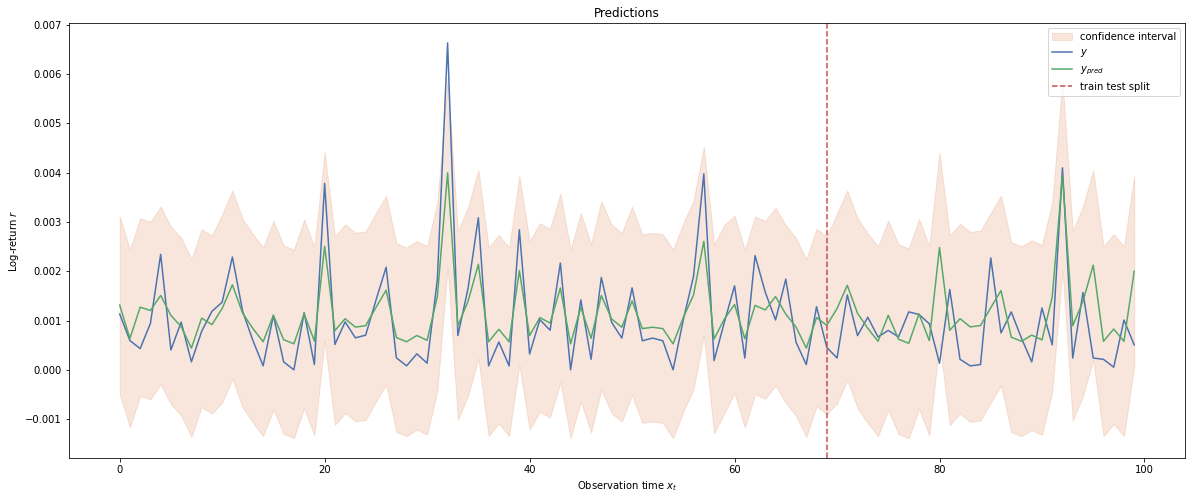

In [24]:
# plot the predictions
fig, ax = plt.subplots(figsize=(20, 8))

ax.fill_between(
    x=data['t'],
    y1=data['pred_upper_bound'],
    y2=data['pred_lower_bound'],
    color=sns.color_palette(palette='deep')[1],
    alpha=0.2,
    label='confidence interval'
)

sns.lineplot(x='t', y='y', data=data, color=sns.color_palette(palette='deep')[0], ax=ax, label=f'$y$')
sns.lineplot(x='t', y='y_pred', data=data, color=sns.color_palette(palette='deep')[2], ax=ax, label=r'$y_{pred}$')

ax.axvline(X_train.shape[0] - 1, color=sns.color_palette(palette='deep')[3], linestyle='--', label='train test split')
ax.legend()
ax.set(title='Predictions', xlabel=r'Observation time $x_t$', ylabel=r'Log-return $r$')

plt.savefig(path + 'gp-all-predictions.png')
plt.show()

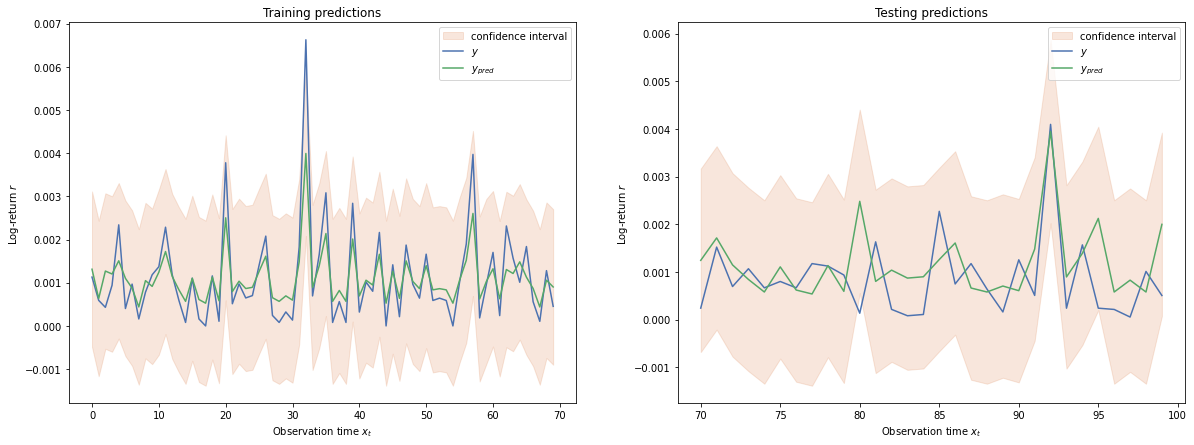

In [25]:
x_plot_train = X_train[..., 0].copy()
x_plot_test = X_test[..., 0].copy()

# store prediction data
results_train = pd.DataFrame({
    'x': x_plot_train,
    'y': data['y'][:x_plot_train.shape[0]],
    'y_pred': data['y_pred'][:x_plot_train.shape[0]], 
    'ub': data['pred_upper_bound'][:x_plot_train.shape[0]],
    'lb': data['pred_lower_bound'][:x_plot_train.shape[0]]
})

results_test = pd.DataFrame({
    'x': x_plot_test,
    'y': data['y'][x_plot_train.shape[0]:],
    'y_pred': data['y_pred'][x_plot_train.shape[0]:], 
    'ub': data['pred_upper_bound'][x_plot_train.shape[0]:],
    'lb': data['pred_lower_bound'][x_plot_train.shape[0]:]
})

# plot the predictions and confidence interval for training
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].fill_between(
    x=x_plot_train,
    y1=results_train['ub'],
    y2=results_train['lb'],
    color=sns.color_palette(palette='deep')[1],
    alpha=0.2,
    label='confidence interval'
)

sns.lineplot(x='x', y='y', data=results_train, color=sns.color_palette(palette='deep')[0], ax=ax[0], label=r'$y$')
sns.lineplot(x='x', y='y_pred', data=results_train, color=sns.color_palette(palette='deep')[2], ax=ax[0], label=r'$y_{pred}$')

ax[0].legend()
ax[0].set(title='Training predictions', xlabel=r'Observation time $x_t$', ylabel=r'Log-return $r$')

# plot the predictions and confidence interval for testing
ax[1].fill_between(
    x=x_plot_test,
    y1=results_test['ub'],
    y2=results_test['lb'],
    color=sns.color_palette(palette='deep')[1],
    alpha=0.2,
    label='confidence interval'
)

sns.lineplot(x='x', y='y', data=results_test, color=sns.color_palette(palette='deep')[0], ax=ax[1], label=r'$y$')
sns.lineplot(x='x', y='y_pred', data=results_test, color=sns.color_palette(palette='deep')[2], ax=ax[1], label=r'$y_{pred}$')

ax[1].legend()
ax[1].set(title='Testing predictions', xlabel=r'Observation time $x_t$', ylabel=r'Log-return $r$')

plt.savefig(path + 'gp-train-test-predictions.png')
plt.show()

### Analysing results

In [26]:
# calculate the coefficient of determination R^2 of the model
R_squared_train = r2_score(results_train['y'], results_train['y_pred'])
R_squared_test = r2_score(results_test['y'], results_test['y_pred'])

# calculate MSE of predictions and test labels
dist_train = results_train['y'] - results_train['y_pred']
err_train = np.square(dist_train)
dist_test = results_test['y'] - results_test['y_pred']
err_test = np.square(dist_test)

RMSE_train = np.sqrt(np.mean(err_train))
RMSE_test = np.sqrt(np.mean(err_test))

# calculate mean absolute percentage error
min_train = results_train['y'][results_train['y'] > 0].min()
y_train_clipped = results_train['y'].copy()
y_train_clipped.replace(0, min_train, inplace=True)
AE_train = (np.abs(results_train['y'] - results_train['y_pred'])) / y_train_clipped
MAPE_train = np.mean(AE_train) * 100

min_test = results_test['y'][results_test['y'] > 0].min()
y_test_clipped = results_test['y'].copy()
y_test_clipped.replace(0, min_test, inplace=True)
AE_test = (np.abs(results_test['y'] - results_test['y_pred'])) / y_test_clipped
MAPE_test = np.mean(AE_test) * 100

# print errors
print('Training R^2:', R_squared_train)
print('Testing R^2:', R_squared_test)

print(f"\nRMSE Train = {RMSE_train}")
print(f"RMSE Test = {RMSE_test}")
print(f"RMSE relative increase = {(RMSE_test / RMSE_train)}")

print(f"\nMAPE Train = {MAPE_train}")
print(f"MAPE Test = {MAPE_test}")
print(f"MAPE relative increase = {(MAPE_test / MAPE_train)}")

Training R^2: 0.7392662302805746
Testing R^2: -0.060063903724230316

RMSE Train = 0.0005615472895397308
RMSE Test = 0.0008348758564136994
RMSE relative increase = 1.4867418505358667

MAPE Train = 122.6806570355507
MAPE Test = 280.737199703674
MAPE relative increase = 2.2883574842798673


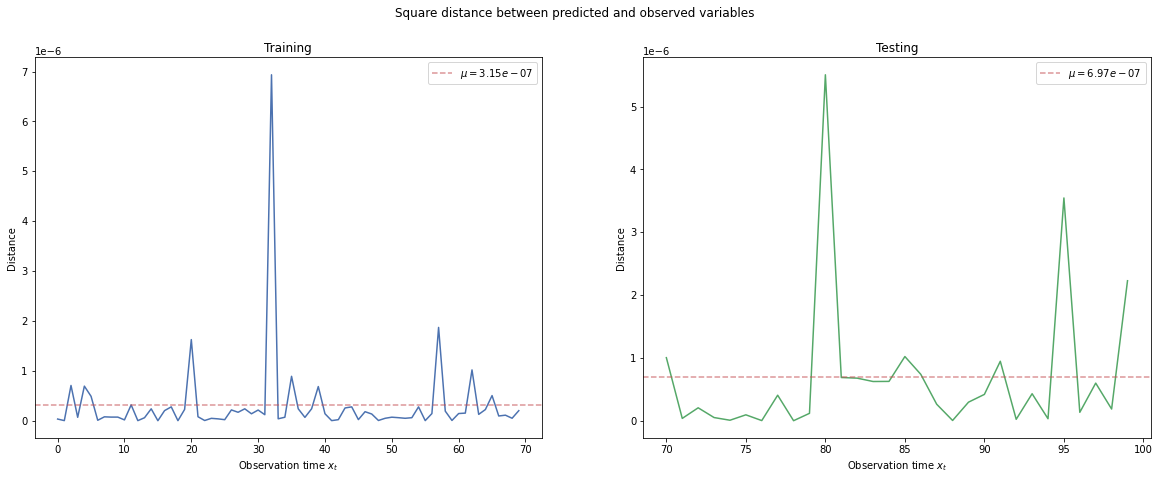

In [27]:
# plot square distances between training/testing labels and predicted labels
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

sns.lineplot(x=results_train['x'], y=err_train, color=sns.color_palette(palette='deep')[0], ax=ax[0])
ax[0].axhline(err_train.mean(), color=sns.color_palette(palette='deep')[3], alpha=0.6, linestyle='--', label=f'$\mu = {err_train.mean():.3}$')

sns.lineplot(x=results_test['x'], y=err_test, color=sns.color_palette(palette='deep')[2], ax=ax[1])
ax[1].axhline(err_test.mean(), color=sns.color_palette(palette='deep')[3], alpha=0.6, linestyle='--', label=f'$\mu = {err_test.mean():.3}$')

fig.suptitle('Square distance between predicted and observed variables')
ax[0].set(title='Training', xlabel=r'Observation time $x_t$', ylabel='Distance')
ax[0].legend()
ax[1].set(title='Testing', xlabel=r'Observation time $x_t$', ylabel='Distance')
ax[1].legend()

plt.savefig(path + 'gp-error-distances.png')
plt.show()

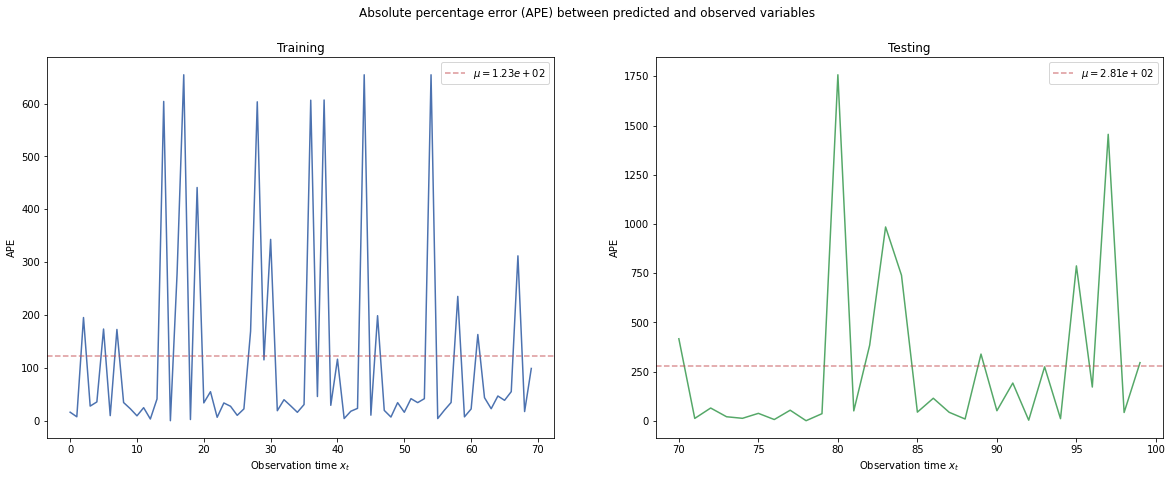

In [28]:
# plot absolute percentage error between training/testing labels and predicted labels
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

APE_train = AE_train * 100
APE_test = AE_test * 100

sns.lineplot(x=results_train['x'], y=APE_train, color=sns.color_palette(palette='deep')[0], ax=ax[0])
ax[0].axhline(APE_train.mean(), color=sns.color_palette(palette='deep')[3], alpha=0.6, linestyle='--', label=f'$\mu = {APE_train.mean():.3}$')

sns.lineplot(x=results_test['x'], y=APE_test, color=sns.color_palette(palette='deep')[2], ax=ax[1])
ax[1].axhline(APE_test.mean(), color=sns.color_palette(palette='deep')[3], alpha=0.6, linestyle='--', label=f'$\mu = {APE_test.mean():.3}$')

fig.suptitle('Absolute percentage error (APE) between predicted and observed variables')
ax[0].set(title='Training', xlabel=r'Observation time $x_t$', ylabel='APE')
ax[0].legend()
ax[1].set(title='Testing', xlabel=r'Observation time $x_t$', ylabel='APE')
ax[1].legend()

plt.savefig(path + 'gp-aperror.png')
plt.show()

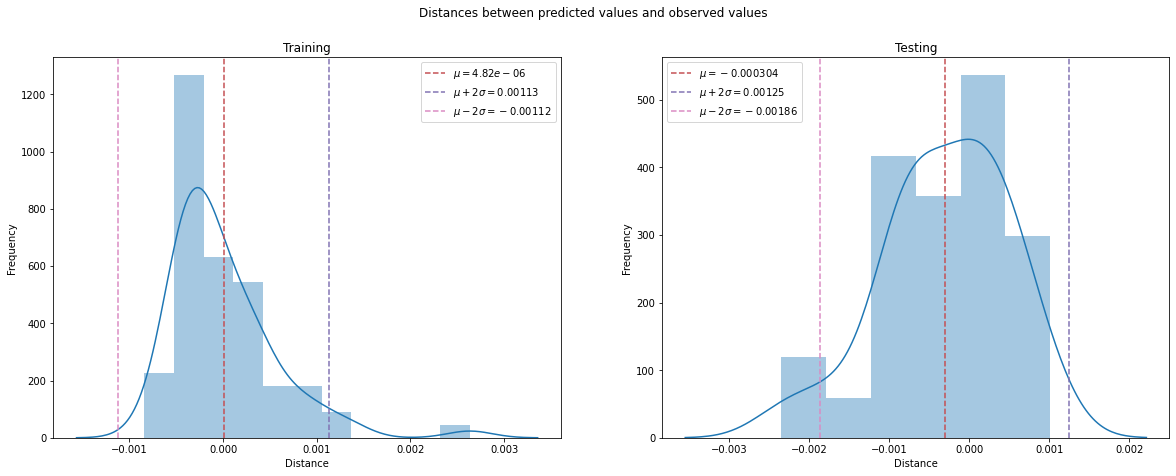

In [29]:
# error plots
err_train_mean, err_test_mean = np.mean(dist_train), np.mean(dist_test)
err_train_std, err_test_std = np.std(dist_train), np.std(dist_test)

ub_train = err_train_mean + 2 * err_train_std
lb_train = err_train_mean - 2 * err_train_std
ub_test = err_test_mean + 2 * err_test_std
lb_test = err_test_mean - 2 * err_test_std

fig, ax = plt.subplots(1, 2, figsize=(20, 7))

sns.distplot(a=dist_train, ax=ax[0])
ax[0].axvline(x=err_train_mean, color=sns.color_palette(palette='deep')[3], linestyle='--', label=f'$\mu = {err_train_mean:.3}$')
ax[0].axvline(x=ub_train, color=sns.color_palette(palette='deep')[4], linestyle='--', label=f'$\mu + 2\sigma = {ub_train:.3}$')
ax[0].axvline(x=lb_train, color=sns.color_palette(palette='deep')[6], linestyle='--', label=f'$\mu - 2\sigma = {lb_train:.3}$')
ax[0].set(title='Training', xlabel='Distance', ylabel='Frequency')
ax[0].legend()

sns.distplot(a=dist_test, ax=ax[1])
ax[1].axvline(x=err_test_mean, color=sns.color_palette(palette='deep')[3], linestyle='--', label=f'$\mu = {err_test_mean:.3}$')
ax[1].axvline(x=ub_test, color=sns.color_palette(palette='deep')[4], linestyle='--', label=f'$\mu + 2\sigma = {ub_test:.3}$')
ax[1].axvline(x=lb_test, color=sns.color_palette(palette='deep')[6], linestyle='--', label=f'$\mu - 2\sigma = {lb_test:.3}$')
ax[1].set(title='Testing', xlabel='Distance', ylabel='Frequency')
ax[1].legend()

plt.suptitle('Distances between predicted values and observed values')
plt.savefig(path + 'gp-error-distribution.png')
plt.show()